# Predictive Analysis: Airbnb client satisfaction

## Introduction and acknowledgements

We will be exploring data sets scraped from the Airbnb website. Our goal here is to build a model able to achieve a good performance on the task of predicting the rating an apartment will receive based on the other features present on our dataset.

**Acknowledgements/** the data was collected by Tom Slee, available on his website: http://tomslee.net/airbnb-data-collection-methodology-and-accuracy

## Summary

1. Exploratory analysis
2. Feature engineering and processing
3. Model selection
4. Model optimization



## 1. Exploratory analysis

In [2]:
#data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from time import time
from operator import itemgetter
# Stop deprecation warnings from being printed
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
df = pd.read_csv('airbnb_mtl_2017.csv')
#df.head()
len(df)

15871

In [4]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12696 entries, 1406 to 14869
Data columns (total 19 columns):
room_id                 12696 non-null int64
survey_id               12696 non-null int64
host_id                 12696 non-null int64
room_type               12696 non-null object
country                 0 non-null float64
city                    12696 non-null object
borough                 0 non-null float64
neighborhood            12696 non-null object
reviews                 12696 non-null int64
overall_satisfaction    12696 non-null float64
accommodates            12696 non-null int64
bedrooms                12696 non-null float64
bathrooms               0 non-null float64
price                   12696 non-null float64
minstay                 0 non-null float64
last_modified           12696 non-null object
latitude                12696 non-null float64
longitude               12696 non-null float64
location                12696 non-null object
dtypes: float64(9), int64(

In [6]:
train.describe()

,room_id,survey_id,host_id,country,borough,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,minstay,latitude,longitude
count,1.269600e+04,12696.0,1.269600e+04,0.0,0.0,12696.000000,12696.000000,12696.000000,12696.000000,0.0,12696.000000,0.0,12696.000000,12696.000000
mean,1.267355e+07,1556.0,4.251479e+07,NaN,NaN,13.819707,2.732120,3.454001,1.393273,NaN,81.281821,NaN,45.516523,-73.587693
std,6.047078e+06,0.0,4.106833e+07,NaN,NaN,27.689143,2.336281,2.250782,0.960561,NaN,133.089730,NaN,0.027751,0.037102
min,2.078000e+03,1556.0,2.277000e+03,NaN,NaN,0.000000,0.000000,1.000000,0.000000,NaN,9.000000,NaN,45.403320,-73.955358
25%,7.460413e+06,1556.0,8.968515e+06,NaN,NaN,1.000000,0.000000,2.000000,1.000000,NaN,38.000000,NaN,45.500135,-73.602090
50%,1.386658e+07,1556.0,2.837241e+07,NaN,NaN,4.000000,4.500000,3.000000,1.000000,NaN,61.000000,NaN,45.519686,-73.579577
75%,1.837431e+07,1556.0,6.612783e+07,NaN,NaN,13.000000,5.000000,4.000000,2.000000,NaN,97.000000,NaN,45.533547,-73.567239
max,2.036531e+07,1556.0,1.452571e+08,NaN,NaN,384.000000,5.000000,16.000000,13.000000,NaN,8114.000000,NaN,45.698305,-73.481893


In [7]:
train.describe(include=['O'])

,room_type,city,neighborhood,last_modified,location
count,12696,12696,12696,12696,12696
unique,3,1,32,12696,12695
top,Entire home/apt,Montreal,Le Plateau-Mont-Royal,2017-08-10 04:24:12.567361,0101000020E6100000423EE8D9AC6452C08D429259BDC1...
freq,8652,12696,3800,1,2


In [8]:
train.room_type.value_counts()

Entire home/apt    8652
Private room       3925
Shared room         119
Name: room_type, dtype: int64

We can already determine that:
* country, borough, bathrooms and minstay are empty columns that we will delete (1)
* **room_id**, **location** and **host_id** are unique identifying features
* **survey_id** is always 1556.0, **city** is always montreal we will discard them as well (2)

We are not treating this data as a time series, we will therefore **drop last-modified** (3)

We have X numerical variables
* continuous: Price, overall satisfaction
* discrete: host_id, accomodates, reviews

We have Y categorical variables:
* room_type with 3 categories: "Entire home/apt", "Shared room", "Private room"
* neighborhood: 32 of the different neighborhoods in montreal

We will want to rework the geographic information to make it a value we can use with machine learning

### Looking at the review (target) variable

In [9]:
train['overall_satisfaction'].describe()

count    12696.000000
mean         2.732120
std          2.336281
min          0.000000
25%          0.000000
50%          4.500000
75%          5.000000
max          5.000000
Name: overall_satisfaction, dtype: float64

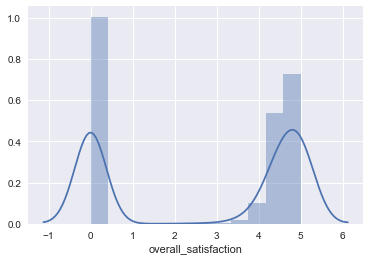

In [10]:
#histogram
sns.distplot(train['overall_satisfaction']);

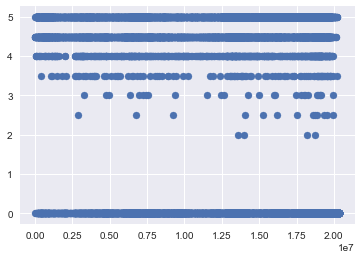

In [11]:
plt.scatter(train['room_id'], train['overall_satisfaction']);
plt.show()

It is important to note that most of the 0 reviews come from listings that were not rated, therefore we will drop all the listing that were not rated from the sample (4)

In [12]:
train.overall_satisfaction.value_counts()

0.0    5315
5.0    3851
4.5    2842
4.0     535
3.5     109
3.0      27
2.5      13
2.0       4
Name: overall_satisfaction, dtype: int64

It is however intriguing that so many of the ratings are above 3 and virtually none them is between 1 and 3. After further research and comparing with other airbnb datasets, in turns out it is a recurrent problem in airbnb ratings, a disproportionate amount of the ratings is above 4.5, it could be interesting to look at how ratings are computed and further inquire that review system that seems fairly flawed. For now we will try to see if we can obtain a good accuracy in predicting them anyways.

In [13]:
train.host_id.value_counts().head()

12243051    116
778430       41
38459934     33
318040       29
16189500     25
Name: host_id, dtype: int64

some host have several postings, we could create a new feature linking of the number of postings of the owner to each room, to see if the experience of a host correlates with the quality of the rankings

## 2. Feature engineering and processing

In [14]:
#dropping the dicussed columns
df = df.drop(["country","survey_id","last_modified","city","borough","bathrooms","minstay"], axis=1)


In [15]:
train.reviews.value_counts().head()

0    2809
1    1428
2    1074
3     777
4     671
Name: reviews, dtype: int64

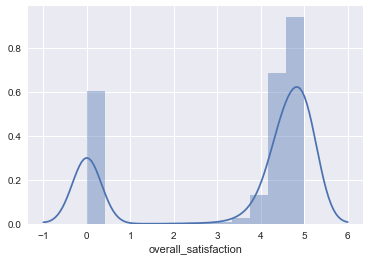

In [16]:
#Dropping 0 columns
df = df[df.reviews != 0]

sns.distplot(df['overall_satisfaction']);

In [17]:
revs = train.reviews.value_counts()
df[df["overall_satisfaction"]  == 0];

There is still a significant number of 0 ratings. Part of the reason is the fact that people who review do not HAVE to leave a ratings, they CAN leave a rating in addition to their review. That adds an interesting component to our prediction since most of those 0 ratings are due to the fact that people did not rate the appartment. We could either discard them assuming that is the case, or keep the ratings, technically we are still solving the same question of "What will the rating" be, however there is a new dimension to it: "Will there be a rating ?" We unfortunately cannot clearly separate both here without making some really strong assumptions so we will see how our predictive models perform with the 0 ratings in the set.

In [18]:
train.head()

,room_id,survey_id,host_id,room_type,country,city,borough,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,minstay,last_modified,latitude,longitude,location
1406,16402905,1556,16862291,Entire home/apt,NaN,Montreal,NaN,Rosemont-La Petite-Patrie,3,5.0,4,2.0,NaN,163.0,NaN,2017-08-10 09:19:31.118765,45.531519,-73.610592,0101000020E6100000C0CC77F0136752C0F01989D008C4...
8627,18273924,1556,126339362,Entire home/apt,NaN,Montreal,NaN,Le Plateau-Mont-Royal,23,5.0,4,1.0,NaN,62.0,NaN,2017-08-10 04:48:11.067312,45.508727,-73.577822,0101000020E6100000323A2009FB6452C0CDCB61F71DC1...
9641,16303561,1556,43034174,Entire home/apt,NaN,Montreal,NaN,LaSalle,24,4.5,2,0.0,NaN,33.0,NaN,2017-08-10 04:24:07.175204,45.428457,-73.636900,0101000020E6100000A2B437F8C26852C0035FD1ADD7B6...
10170,16324612,1556,3149476,Entire home/apt,NaN,Montreal,NaN,Rosemont-La Petite-Patrie,20,5.0,2,1.0,NaN,40.0,NaN,2017-08-10 04:14:05.195303,45.551811,-73.595531,0101000020E610000044300E2E1D6652C05A492BBEA1C6...
6247,18430037,1556,84766143,Entire home/apt,NaN,Montreal,NaN,Ville-Marie,22,5.0,4,1.0,NaN,81.0,NaN,2017-08-10 06:18:53.370201,45.495864,-73.567689,0101000020E610000022533E04556452C0C2A1B77878BF...


We now need to encode the categorical variables for neighborhood and room_type. Since none of these is ordinal, we will use one hot encoding. (5)

In this first attempt, we will use latitude and longitude to calculate the distance between each place and the heart of downtown montreal, that we will arbitrarily define as the middle of the postal code polygon corresponding to it, situated approximately at 45.505369, -73.566107.

Let us now add a column corresponding to that distance  for each record, using the geopy plugin to compute the distance between two points

In [19]:
from geopy.distance import vincenty
downtown_mtl = (45.505369, -73.566107)
#cleveland_oh = (41.499498, -81.695391)
#print(vincenty(downtown_mtl, cleveland_oh).miles)

#the vincenty function uses the vincenty formula to compute the distance between two points defined by their
#latitude and longitude
df['downtown_dist'] = df.apply (lambda row: vincenty((row['latitude'], row['longitude']), downtown_mtl).kilometers,axis=1)


In [20]:
df.head()

,room_id,host_id,room_type,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,latitude,longitude,location,downtown_dist
0,15023220,90096724,Shared room,Rosemont-La Petite-Patrie,4,5.0,1,1.0,52.0,45.544091,-73.594396,0101000020E6100000E33785950A6652C023861DC6A4C5...,4.837937
1,1132103,4162573,Shared room,Ville-Marie,20,5.0,1,1.0,53.0,45.506773,-73.568754,0101000020E6100000075E2D77666452C077BF0AF0DDC0...,0.259116
4,7067433,36987539,Shared room,Verdun,5,5.0,2,1.0,14.0,45.458891,-73.571854,0101000020E61000008E058541996452C0E1B6B6F0BCBA...,5.185125
5,13274638,20707779,Shared room,Rosemont-La Petite-Patrie,2,0.0,2,1.0,20.0,45.547610,-73.574754,0101000020E6100000B14F00C5C86452C0357BA01518C6...,4.743102
6,12851518,70209623,Shared room,Rosemont-La Petite-Patrie,1,0.0,1,1.0,12.0,45.551003,-73.575831,0101000020E61000007841446ADA6452C0BB7F2C4487C6...,5.128429


We will for now get rid of the latitude longitude and location string.

In [21]:
df.drop(["latitude", "longitude", "location"], axis = 1, inplace=True)


Let us now perform one hot encoding using the pandas get dummies functions

In [22]:
df = pd.get_dummies(df)

## 3. Model Selection

We will now split our data into a train and test set and more closely look at the correlations

Let us first try to handle the outputs as a continuous variable. If that does that not work well, we will consider handling them as discrete numerical values, since the possible more scores are from 0.0 to 5.0 with .5 increments.

This is not working at all, why ? because we are checking for exact values while using a continuous variable, we could either add an interval of confidence or turn towards classification models.

In [23]:
#Converting integers to floats in order to be able to handle them as categorical variables
df['overall_satisfaction'] = df['overall_satisfaction'].apply(lambda x: int(x))

In [24]:
#Perform the split again, this time on the modified data
from sklearn.model_selection import train_test_split
train2, test2 = train_test_split(df, test_size=0.2)


#Preparing and splitting our sets into development and evaluation
X_train = train2.drop("overall_satisfaction", axis=1)
y_train = train2.overall_satisfaction.values

X_test = test2.drop("overall_satisfaction", axis=1)
y_test = test2.overall_satisfaction.values

In [25]:
X_test

,room_id,host_id,reviews,accommodates,bedrooms,price,downtown_dist,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,...,neighborhood_Pointe-Claire,neighborhood_Rivière-des-Prairies-Pointe-aux-Trembles,neighborhood_Rosemont-La Petite-Patrie,neighborhood_Saint-Laurent,neighborhood_Saint-Léonard,neighborhood_Sainte-Anne-de-Bellevue,neighborhood_Verdun,neighborhood_Ville-Marie,neighborhood_Villeray-Saint-Michel-Parc-Extension,neighborhood_Westmount
2253,5536981,4153452,15,4,2.0,106.0,3.140926,1,0,0,...,0,0,0,0,0,0,0,0,0,0
11842,11106229,44950761,13,2,1.0,48.0,2.324635,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4669,18636682,10022566,10,4,2.0,81.0,0.559610,1,0,0,...,0,0,0,0,0,0,0,0,0,0
15295,18960599,132218343,8,3,1.0,33.0,7.374435,0,1,0,...,0,0,1,0,0,0,0,0,0,0
11527,14321598,17735943,1,4,1.0,98.0,5.283270,0,1,0,...,0,0,0,0,0,0,0,0,1,0
13788,682063,926590,14,2,1.0,30.0,3.466661,0,1,0,...,0,0,0,0,0,0,0,0,0,0
10267,6713899,34958260,53,2,1.0,37.0,5.260850,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8499,16143321,2293824,2,4,2.0,57.0,6.275303,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3730,19470930,103610327,12,9,3.0,98.0,1.152985,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14667,14094354,15440055,1,2,1.0,20.0,3.126343,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

from sklearn.model_selection import cross_val_score

#Performing a 10-fold cross validation
scores = cross_val_score(logreg, X_train, y_train, cv=10)
print(scores)
print(scores.mean())

#Note: "Too many indices in array" error raised whenever Y is a pandas df instead of a numpy array.
#Note2: X being a df does not seem to be a problem.

[ 0.40040445  0.3983822   0.39737108  0.39878543  0.39716312  0.39817629
  0.39655172  0.39796954  0.39939024  0.39735772]
0.398155180731


Idea for future development: add some NLP component/sentiment analysis on the written review.

In [27]:
#KNeighborsClassifier

KNN = KNeighborsClassifier(n_neighbors = 3)
##knn.fit(train_X, train_y)
##pred_y = knn.predict(test_X)

scores = cross_val_score(KNN, X_train, y_train, cv=10)
print(scores)
print(scores.mean())

[ 0.3892821   0.39939333  0.36703741  0.38461538  0.3698075   0.36575481
  0.39452333  0.38680203  0.38313008  0.36788618]
0.380823215309


In [28]:
# Gaussian Naive Bayes

GS = GaussianNB()
#gaussian.fit(train_X, train_y)
#pred_y = gaussian.predict(test_X)


scores = cross_val_score(GS, X_train, y_train, cv=10)
print(scores)
print(scores.mean())

[ 0.38523761  0.39635996  0.37714863  0.36437247  0.38399189  0.41236069
  0.39046653  0.36345178  0.39634146  0.40650407]
0.387623509806


In [31]:
#Single Decision Tree

DCT = DecisionTreeClassifier()

#decision_tree.fit(train_X, train_y)
#pred_y = decision_tree.predict(test_X)


scores = cross_val_score(DCT, X_train, y_train, cv=10)
print(scores)
print(scores.mean())

[ 0.64610718  0.6380182   0.64610718  0.64777328  0.65450861  0.63120567
  0.6653144   0.65583756  0.65853659  0.64735772]
0.649076639722


Since a **Single decision tree** performed well compared to the other models, we will give **Random Forest** a try.

In [29]:
# Random Forest

RDF = RandomForestClassifier(n_estimators=100)
#random_forest.fit(train_X, train_y)
#pred_y = random_forest.predict(test_X)


scores = cross_val_score(RDF, X_train, y_train, cv=10)
print(scores)
print(scores.mean())

[ 0.69565217  0.70879676  0.7057634   0.6902834   0.67781155  0.69604863
  0.70081136  0.71979695  0.69715447  0.69918699]
0.699130569563


It seems that random forest is a good candidate here for **further optimization**.

## 4. Model Tuning and performance improvement

There are several things we could do and assess to try improving the accuracy of our model:

1. It could be interesting to try using **boosting trees** since random forest worked well
2. We should take a look at the distribution of the errors to see if most guesses go to to the over-represented classes in the training set.
3. We will take a look at the learning curve for a range of values on the number of features considered for the split.


### Let us first plot the errors to get some intuition about the possible improvements

In [32]:
#grid_search.best_params_ {'criterion': 'gini', 'max_features': 0.5, 'n_estimators': 500}

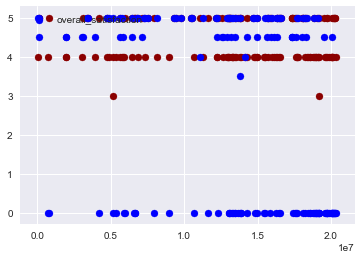

In [33]:
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier(random_state = 84) #random seed for reproducibility

clf.fit(X_train, y_train);
prediction = clf.predict(X_test)

correct_idx = np.where(prediction == y_test)[0]

incorrect_idx = np.where(prediction != y_test)[0]

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(test['room_id'][incorrect_idx], prediction[incorrect_idx], color="darkred")
ax1.scatter(test['room_id'][incorrect_idx], test.overall_satisfaction[incorrect_idx], color="blue")
plt.legend(loc='upper left');
plt.show()

In [ ]:
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

It looks like most of wrong predictions are on test samples that received a rating of 0 or 4.5, Let's compare the distribution of our predictions to the distribution of the sample

Just of curiosity, let's see if gradient boosting performs better out of the box.

In [37]:
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingClassifier

num_trees = 100
seed = 84
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = GradientBoostingClassifier(n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)

array([ 0.71428571,  0.7183384 ,  0.7183384 ,  0.71023303,  0.72137791,
        0.71327254,  0.71023303,  0.70111449,  0.68965517,  0.69371197])

In [40]:
results.mean()


0.70905606556635858

The nexts steps will be to refine our tuning and scale up to use datasets from other cities.